In [1]:
"""
Import statements and utility functions
"""

import numpy as np
import matplotlib.pyplot as plt

# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

def plot_loss_gradNorm(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["losses"], label="Loss")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["grad_norms"], label="Gradient Norm")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

### ELM

In [2]:
class ELM:
    """
    Extreme Learning Machine for a single-hidden-layer feedforward neural network (SLFN).
    """

    def __init__(self, input_size, hidden_size, output_size,
                 l1_lambda=0.0, activation='relu', seed=None):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1_lambda = l1_lambda

        if seed is not None:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            self.activation_deriv = None

        # Randomly init input->hidden (fixed in ELM)
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization for ReLU
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = 0.2 * np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights (trainable) + bias
        limit_out = 0.2 * np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Forward-pass placeholders
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ---------------------------------------------------------
    # Activation utilities
    # ---------------------------------------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient helper
    def _l1_subgrad(self, w):
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ---------------------------------------------------------
    # Forward / backward pass
    # ---------------------------------------------------------
    def forward(self, X):
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.output_layer_input  # linear output
        return self.predicted_output

    def backward(self, X, y):
        """
        For ELM, we only update hidden->output weights, so compute dW2, db2.
        MSE derivative + L1 subgradient.
        """
        n_samples = X.shape[0]
        # derivative wrt output = (pred - y)
        output_error = (self.predicted_output - y)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples

        # add L1 subgradient
        dW2 += self.l1_lambda * self._l1_subgrad(self.weights_hidden_output)
        return dW2, db2

    def evaluate_loss(self, X, y):
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term

    def predict(self, X):
        hidden = self.activation(X.dot(self.weights_input_hidden) + self.bias_hidden)
        return hidden.dot(self.weights_hidden_output) + self.bias_output

    # ---------------------------------------------------------
    # Parameter pack/unpack
    # ---------------------------------------------------------
    def _pack_params(self, W_out, b_out):
        """
        Flatten and concatenate trainable parameters into one vector.
        """
        return np.concatenate([W_out.ravel(), b_out.ravel()])

    def _unpack_params(self, theta):
        """
        Unpack flattened vector theta into ELM's W_out, b_out shapes.
        """
        w_size = self.hidden_size * self.output_size
        w = theta[:w_size].reshape((self.hidden_size, self.output_size))
        b = theta[w_size:].reshape((1, self.output_size))

        self.weights_hidden_output = w
        self.bias_output = b

    # ---------------------------------------------------------
    # Generic training via user-provided optimizer
    # ---------------------------------------------------------
    def train(self, X, y, optimizer, **optimizer_args):
        """
        Train ELM using a user-supplied optimizer function with signature:
            optimizer( f, theta_init, ... ) -> (theta_opt, history)

        We define 'f(theta)' to return (loss, grad, None).
        """
        # Define objective function: f(theta) => (loss, gradient, _)
        def objective(theta):
            # 1) Unpack new parameters into the model
            self._unpack_params(theta)

            # 2) Forward pass
            self.forward(X)
            # 3) Compute loss
            loss = 0.5 * np.mean((self.predicted_output - y) ** 2)
            loss += self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))

            # 4) Backward pass => gradient wrt W_out, b_out
            dW2, db2 = self.backward(X, y)
            # Flatten gradient
            grad = self._pack_params(dW2, db2)
            return loss, grad, None

        # Pack initial parameters for the optimizer
        theta_init = self._pack_params(self.weights_hidden_output, self.bias_output)

        # Run user-supplied optimizer
        theta_opt, history = optimizer(objective, theta_init, **optimizer_args)

        # Unpack best parameters back into model
        self._unpack_params(theta_opt)

        return history

    def get_parameters(self):
        return {
            "weights_hidden_output": self.weights_hidden_output,
            "bias_output": self.bias_output
        }

    def set_parameters(self, params):
        self.weights_hidden_output = params["weights_hidden_output"]
        self.bias_output = params["bias_output"]

In principle $M$, being the Lipshitz constant of the gradient of the smooth part of the function (in our case the MSE component), can be estimated through the maximum eigenvalue of the Hessian matrix. In the neural network case of this problem, the Hessian with respect to $W_2$ would be $$\nabla^2 \bigl\|W_2\sigma(W_1 x) - y\bigr\|^2$$ and $M$ would correspond to its maximum value. To explicitly determine the constant $M$ (Lipschitz constant of the gradient of the quadratic part) it is sufficient to calculate the maximum eigenvalue of the Hessiana of the function $\|W_2\sigma(W_1x) - y\|^2$ with respect to $W_2$. If in the problem we have:

- $N$ samples $\{x_i,y_i\}_{i=1}^N$,
- $W_1\in\mathbb{R}^{L\times d}$ (weights _fixed_ input$\to$hidden),
- $\sigma(\cdot)$ activation (here taken as an element-wise function),
- $W_2\in\mathbb{R}^{L\times m}$ (towable weights hidden$\to$output),
- $H\in\mathbb{R}^{N\times L}$ the matrix stacking the hidden features (row $i$ corresponding to $\sigma(W_1x_i)$),

then the smooth part to be optimized is:
$$
g(W_2)\;=\;\bigl\|\,H\,W_2^\top \;-\;Y\,\bigr\|_F^{2}
\quad\text{(if }m>1\text{, otherwise }\|HW_2 - y\|^2 \text{).}
$$
The Hessian matrix of $g$ with respect to $W_2$ (in the case $m=1$ for simplicity) results:
$$
\nabla^2 g(W_2)\;=\;2\,H^\top\,H,
$$
and thus the maximum eigenvalue of $\nabla^2 g(W_2)$ is $2\,\lambda_{\max}(H^\top\ H)$. But $\lambda_{\max}(H^\top H)$ is precisely the square of the singular maximum of $H$, that is, $\sigma_{\max}(H)^2$. Therefore, the Lipschitz constant $M$ (which governs the “curvature” of $g$) is
$$
\boxed{\,M \;=\; 2\,\|H\|_{2}^{2}\;=\;2\,\bigl(\sigma_{\max}(H)\bigr)^2.}
$$

Where $\|H\|_{2}$ is the spectral norm (or singular maximum) of $H$. In other words:
1. Construct $H$ (dimension $N\times L$), whose elements are $H_{i,:} = \sigma(W_1 x_i)$.
2. Run SVD (or eigenvalues of $H^\top H$) to find $\sigma_{\max}(H)$.
3. Calculate $M = 2\,\sigma_{\max}(H)^2$.

In [3]:
# ---------------------------------------------------------
# Compute Lipschitz constant of MSE
# ---------------------------------------------------------
def compute_mse_lipschitz_constant(model, X):
    """
    Calcola la costante di Lipschitz M dell'MSE
    (parte smooth della loss):
      M = (sigma_max(H)^2) / n_samples
    dove H = activation(X.dot(weights_input_hidden)+bias_hidden).

    Parameters:
    X: np.ndarray, shape (n_samples, input_size)
      Input data.

    Returns:
    M: float
      Lipschitz constant.
    """
    # 1) Calcolo H
    hidden_inp = X.dot(model.weights_input_hidden) + model.bias_hidden
    H = model.activation(hidden_inp)  # shape: (n_samples, hidden_size)

    # 2) Calcolo singolare massima di H
    sigma_max = np.linalg.norm(H, ord=2)  # massima singolare (norma spettrale)

    # 3) Definisco M
    n_samples = X.shape[0]
    M = (sigma_max**2) / n_samples

    return M

Note:
- **Hessian Matrix**: square matrix that contains the second derivatives of a function.

Fonti esatte:
- Relazione tra Lipschitz-continuity del gradiente e autovalori della matrice Hessiana: https://cs.mcgill.ca/~wlh/comp451/files/comp451_chap8.pdf
> Conseguenza del **Teorema 2** (pag. 64): *In formal terms, Lipschitz continuity of the gradient implies that the Hessian matrix (which contains the second derivatives) has eigenvalues bounded above by L.*
- MSE con Lipschitz constant citato in https://www.diva-portal.org/smash/get/diva2:1882587/FULLTEXT01.pdf, ma non si capisce benissimo????
- Lipschitz constant di una funzione come massima norma del suo gradiente: **Teorema 1** (pag. 2) in https://arxiv.org/pdf/1805.10965

### DATA

In [4]:
def generate_synthetic_regression_data(n_samples=1000, n_features=50, noise=0.1, random_seed=42):
    """
    Generates a single-output regression dataset:
        y = sin(2*pi*x_0) + Gaussian noise
    with x in [0, 1].
    """
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features)  # shape (n_samples, n_features)

    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-10
    X = (X - X_mean) / X_std

    # Use just the first feature for generating the target,
    # so the target y is (n_samples,) or (n_samples, 1).
    y_true = np.sin(2 * np.pi * X[:, 0])  # shape (n_samples,)

    # Add random noise
    y_noisy = y_true + noise * np.random.randn(n_samples)
    # Optionally reshape to (n_samples, 1) if your code expects 2D:
    y_noisy = y_noisy.reshape(-1, 1)

    return X, y_noisy

X_syn, y_syn = generate_synthetic_regression_data(n_samples=3000, n_features = 50, noise=0.1, random_seed=42)
# summary statistics
print(f"X shape: {X_syn.shape}, y shape: {y_syn.shape}")
print(f"X range: {X_syn.min():.2f} to {X_syn.max():.2f}")
print(f"y range: {y_syn.min():.2f} to {y_syn.max():.2f}")

X shape: (3000, 50), y shape: (3000, 1)
X range: -1.78 to 1.78
y range: -1.24 to 1.33


In [5]:
def load_california_housing_data(random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

X_cal, y_cal = load_california_housing_data()
print(f"X shape: {X_cal.shape}, y shape: {y_cal.shape}")

X shape: (20640, 8), y shape: (20640, 1)


# NAG

In [6]:
def NAG(f, theta, epsilon, eta, tol, max_iters, grad_norm_threshold=None, loss_threshold=1e10):
    """
    Nesterov's Accelerated Gradient (NAG) method for unconstrained optimization.

    Parameters:
        f (function): Function that returns (value, gradient, Hessian).
        theta (np.array): Initial parameter vector.
        epsilon (float): Learning rate.
        eta (float): Momentum coefficient.
        tol (float): Convergence tolerance.
        max_iters (int): Maximum number of iterations.
        grad_norm_threshold (float, optional): Stopping criterion based on gradient norm.
        loss_threshold (float): Upper bound to stop if loss explodes.

    Returns:
        theta (np.array): Optimized parameters.
        history (dict): Contains losses, gradient norms, and trajectory.
    """
    v = np.zeros_like(theta)
    history = {"losses": [], "grad_norms": [], "trajectory": [theta.copy()]}

    for t in range(1, max_iters + 1):
        theta_lookahead = theta + eta * v
        loss, grad, _ = f(theta_lookahead)

        # Check if loss exploded
        if np.abs(loss) > loss_threshold or np.isnan(loss):
            print(f"Stopping early due to unstable loss at iteration {t}")
            break

        # Ensure `grad` is not None before computing norm
        if grad is None:
            print(f"Gradient is None at iteration {t}, stopping optimization.")
            break

        grad_norm = np.linalg.norm(grad)
        history["losses"].append(loss)
        history["grad_norms"].append(grad_norm)

        #print(f"Iter {t:3d} | Loss: {loss:.6f} | Grad Norm: {grad_norm:.6f}")

        if grad_norm < tol or (grad_norm_threshold and grad_norm < grad_norm_threshold):
            print("Convergence reached based on gradient norm.")
            break

        v = eta * v - epsilon * grad
        theta = theta.astype(float) + v
        history["trajectory"].append(theta.copy())

    return theta, history

# Smoothed

In [7]:
def smoothed(
    f,
    theta_init,
    A_norm,
    epochs=1000,
    M = 0.0,
    mu=1e-2,
    sigma_2=1.0,
    momentum_init=0.9,
    gradient_norm_threshold=None
):

    # 1) The Lipschitz constant
    mu = A_norm/(M*sigma_2)
    L_L1 = (1.0 / (mu * sigma_2)) * A_norm
    L_mu = M + L_L1
    nu = 1.0 / L_mu
    print("------ PARAMETERS ------")
    print(f"M = {M}")
    print(f"sigma_2 = {sigma_2}")
    print(f"mu = {mu}")
    print(f"L_L1 = {L_L1}")
    print(f"L_mu = {L_mu}")
    print(f"nu (learning rate) = {nu}")
    print("------------------------")

    # momentum
    v = np.zeros_like(theta_init)
    theta = theta_init.copy()
    eta = momentum_init

    history = {"losses": [], "grad_norms": [], "theta": []}

    for epoch in range(epochs):
        theta_look = theta + eta * v
        loss, grad, _ = f(theta_look)
        gn = np.linalg.norm(grad)

        history["losses"].append(loss)
        history["grad_norms"].append(gn)
        history["theta"].append(theta_look.copy())

        if gradient_norm_threshold is not None and gn < gradient_norm_threshold:
            print(f"Stopping early at epoch {epoch}, grad norm < {gradient_norm_threshold}")
            break

        # momentum update
        v = eta * v - nu * grad
        theta = theta + v

    return theta, history

------ PARAMETERS ------
M = 2.0
sigma_2 = 2.0
mu = 1.0
L_L1 = 2.0
L_mu = 4.0
nu (learning rate) = 0.25
------------------------
Stopping early at epoch 37, grad norm < 1e-06


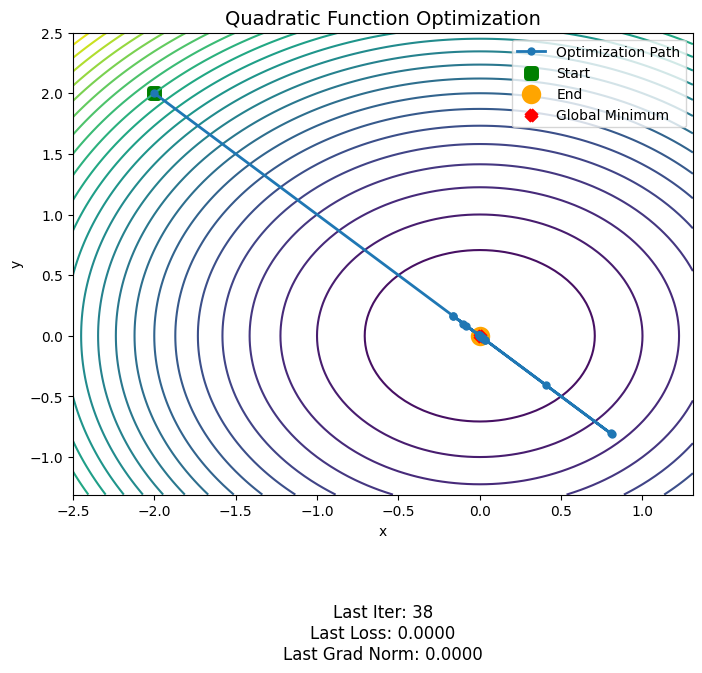

In [8]:
# test on a simple quadratic function

def quadratic(x, Q=None, q=None, global_minimum = np.array([0, 0])):
  """ Quadratic function: f(x) = 0.5 * x'Qx + q'x """
  if Q is None:
      Q = np.array([[2, 0], [0, 2]])  # Default positive definite matrix
  if q is None:
      q = np.array([0, 0])  # Default linear term

  if x is None:
      if np.min(np.linalg.eigvals(Q)) > 1e-14:
          x_star = np.linalg.solve(Q, -q)
          v = 0.5 * x_star.T @ Q @ x_star + q.T @ x_star
      else:
          v = -np.inf
      return v, np.array([0, 0]), Q
  else:
      v = 0.5 * x.T @ Q @ x + q.T @ x
      g = Q @ x + q
      H = Q
      return v, g, H

def plot_contours(optimizer):
    """ Plot function level sets and optimization trajectory. """
    theta_init = np.array([-2.0, 2.0])

    Q = np.array([[2, 0],
                  [0, 2]])

    # Per questa Q, la minima autovalore = 2, massima autovalore = 2.
    sigma_2 = np.min(np.linalg.eigvals(Q))
    M = np.max(np.linalg.eigvals(Q))

    A_norm = np.linalg.norm(Q, ord=2)**2  # = 4

    # Ora chiami l’optimizer passando i parametri corretti
    theta_final, history = optimizer(
        quadratic,
        theta_init,
        A_norm=A_norm,
        M=M,
        sigma_2=sigma_2,
        epochs=500,
        momentum_init=0.9,
        gradient_norm_threshold=1e-6
    )

    # Salvi la "trajectory" delle soluzioni
    trajectory = np.array(history["theta"])
    x_min, x_max = np.min(trajectory[:, 0]) - 0.5, np.max(trajectory[:, 0]) + 0.5
    y_min, y_max = np.min(trajectory[:, 1]) - 0.5, np.max(trajectory[:, 1]) + 0.5
    x_vals = np.linspace(x_min, x_max, 100)
    y_vals = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for rr in range(X.shape[0]):
        for cc in range(X.shape[1]):
            v, _, _ = quadratic(np.array([X[rr, cc], Y[rr, cc]]), Q=Q)
            Z[rr, cc] = v

    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, levels=30)
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label='Optimization Path', markersize=5, lw=2)
    plt.scatter(trajectory[0, 0], trajectory[0, 1], marker='s', color="green", label='Start', lw=5)
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], marker='o', color="orange", label='End', lw=8)

    global_min = np.array([0, 0])
    plt.scatter(global_min[0], global_min[1], marker='x', color='red', label='Global Minimum', lw=6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Quadratic Function Optimization", fontsize=14)
    plt.legend()

    last_iter = len(history["losses"])
    last_loss = history["losses"][-1] if history["losses"] else float('nan')
    last_grad_norm = history["grad_norms"][-1] if history["grad_norms"] else float('nan')

    plt.text(0.5, -0.3, f"Last Iter: {last_iter}\nLast Loss: {last_loss:.4f}\nLast Grad Norm: {last_grad_norm:.4f}",
             horizontalalignment='center',
             verticalalignment='center',
             transform=plt.gca().transAxes,
             fontsize=12)
    plt.show()

plot_contours(smoothed)

In [16]:
model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

# 1) Compute the hidden activation matrix once
model.forward(X_syn)
H = model.hidden_layer_output  # shape (N, hidden_size)
rank_H = np.linalg.matrix_rank(H)
print(f"Rank di H: {rank_H} su {H.shape[1]}")

'''
A_norm = np.linalg.norm(H, ord=2)**2  # largest singular value squared

This is correct if you consider smoothing the gradient of the MSE loss, where A corresponds to the hidden layer activation matrix H.
However, for the smoothing of the L1-norm, you should use A_norm = 1 because A is the identity matrix for the L1 norm smoothing
'''

A_norm = 1

sigma_2 = np.min(np.linalg.eigvals(H.T @ H))  # H.T @ H è quadrata di dim (hidden_size, hidden_size); # strong convexity parameter: minimo autovalore dell'Hessiana
print(f'Sigma2: {sigma_2}')

M = compute_mse_lipschitz_constant(model, X_syn)
print(f"Lipschitz constant: {M}")

Rank di H: 200 su 200
Sigma2: 162.76605294824475
Lipschitz constant: 65.4205196325065


------ PARAMETERS ------
M = 65.4205196325065
sigma_2 = 162.76605294824475
mu = 9.391223547862945e-05
L_L1 = 65.4205196325065
L_mu = 130.841039265013
nu (learning rate) = 0.007642861946201316
------------------------


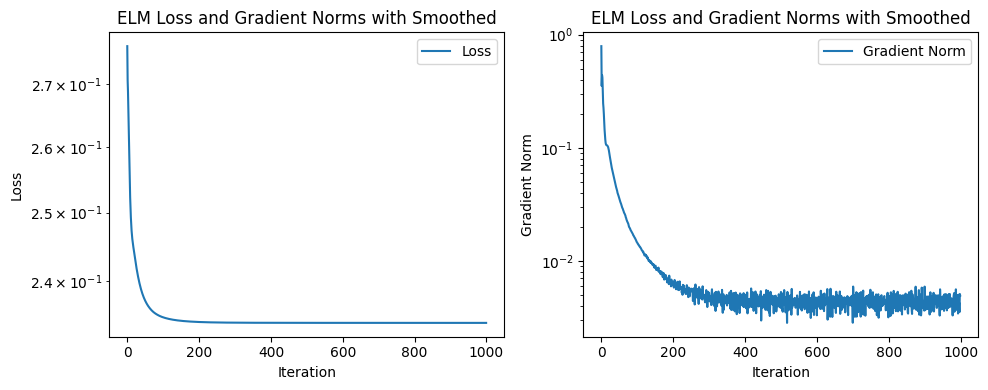

In [17]:
history = model.train(
    X_syn, y_syn,
    A_norm = A_norm,
    optimizer=smoothed,
    epochs=1000,
    M = M,
    sigma_2=sigma_2,
    momentum_init=0.9,
    gradient_norm_threshold=1e-6
)

plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

#### Sigma2
In practice, the smallest eigenvalue of $H^T H$ can be extremely small or near zero due to rank deficiencies or outlier directions. Directly using the computed $\sigma_2$ leads to very large or unstable Lipschitz-based step-size predictions. As a result, we override it using $\sigma_2=1$ to maintain a stable lower bound on strong convexity, avoiding vanishingly small step sizes.

------ PARAMETERS ------
M = 65.4205196325065
sigma_2 = 1.0
mu = 0.015285723892402632
L_L1 = 65.4205196325065
L_mu = 130.841039265013
nu (learning rate) = 0.007642861946201316
------------------------


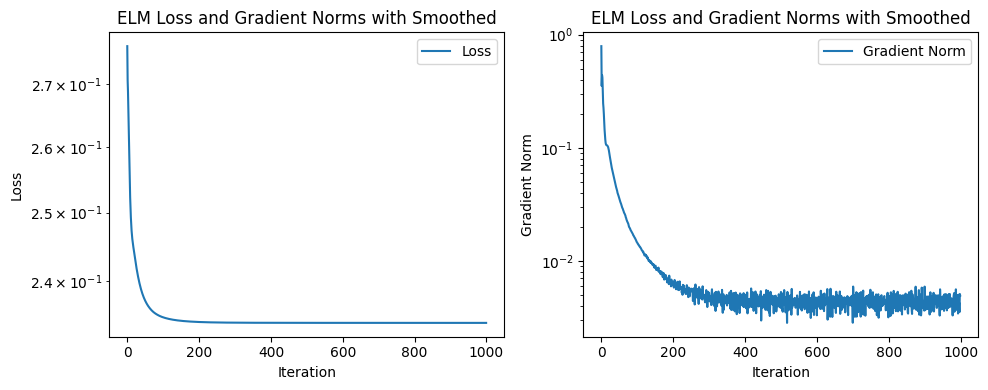

In [18]:
model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)

history = model.train(
    X_syn, y_syn,
    A_norm = A_norm,
    optimizer=smoothed,
    epochs=1000,
    M = M,
    sigma_2=1.0,
    momentum_init=0.9,
    gradient_norm_threshold=1e-6
)

plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

#### MU
1. **Conceptually**:
   - \(\mu\) is the “smoothing knob” for L1’s kink.  
   - **Smaller** \(\mu\) = more faithful to L1, but a larger gradient-Lipschitz constant \(\Rightarrow\) smaller step sizes, slower to converge.  
   - **Larger** \(\mu\) = faster, smoother updates, but less exact “L1-like” corner.  

2. **Theoretical**:
   - Nesterov’s formula \(\mu \approx \epsilon / D_2\) ensures an \(\epsilon\)-approximation to the original function. If you have a fixed iteration budget \(N\), you can use the recommended \(\mu \propto 1/N\) to maximize your iteration efficiency.  
   - But exact numeric constants (like \(\sigma_2\), \(\|A\|_2\), or \(D_2\)) can be quite large or small, so be prepared to refine \(\mu\).

3. **Practical**:
   - Often, you treat \(\mu\) as **another hyperparameter**. Do a small grid or schedule \(\mu\) from large to small.  
   - If \(\mu\) is too small, your step size might become so tiny that training crawls or gets stuck.  
   - If \(\mu\) is too large, you lose the benefits of sparse L1 solutions.

4. **Professional justification**:
   - You can say you “gradually reduce \(\mu\) to let the solution eventually approach a genuinely sparse solution,” or  
   - You fix \(\mu\) in a stable range (like \(\{10^{-4}, 10^{-3}, 10^{-2}, \dots\}\)) that ensures a workable Lipschitz constant for gradient updates.  
   - You can theoretically cite Nesterov’s Lemma or Theorem 2.6 from \cite{Nesterov2005}, but it is common to “clip” or “stage” \(\mu\) in practice for numeric stability.  

Overall, **the best \(\mu\)** is usually found by balancing the desire for accurate L1-induced sparsity vs. the need for stable, faster convergence. Empirically, a short parameter search or a schedule approach is often the most reliable.

GRID-SEARCH:
- computed based on M
- fixed small (test 3 values)
- iterative approach

Running smoothed training with mu_key = computed_M
------ FINAL PARAMETERS ------
FINAL mu = 9.391223547862945e-05
FINAL L_L1 = 65.4205196325065
FINAL L_mu = 130.841039265013
FINAL learning rate nu = 0.007642861946201316
--------------------------------
Running smoothed training with mu_key = fixed_1e-4
------  PARAMETERS ------
 mu = 0.0001
 L_L1 = 61.437872448622514
 L_mu = 126.85839208112901
 learning rate nu = 0.007882805257065499
--------------------------------
Running smoothed training with mu_key = fixed_1e-3
------  PARAMETERS ------
 mu = 0.001
 L_L1 = 6.143787244862252
 L_mu = 71.56430687736875
 learning rate nu = 0.013973446311910505
--------------------------------
Running smoothed training with mu_key = fixed_1e-2
------  PARAMETERS ------
 mu = 0.01
 L_L1 = 0.6143787244862251
 L_mu = 66.03489835699273
 learning rate nu = 0.015143507825118134
--------------------------------
Running smoothed training with mu_key = iterative_computed
------ FINAL PARAMETERS ------
FINAL mu

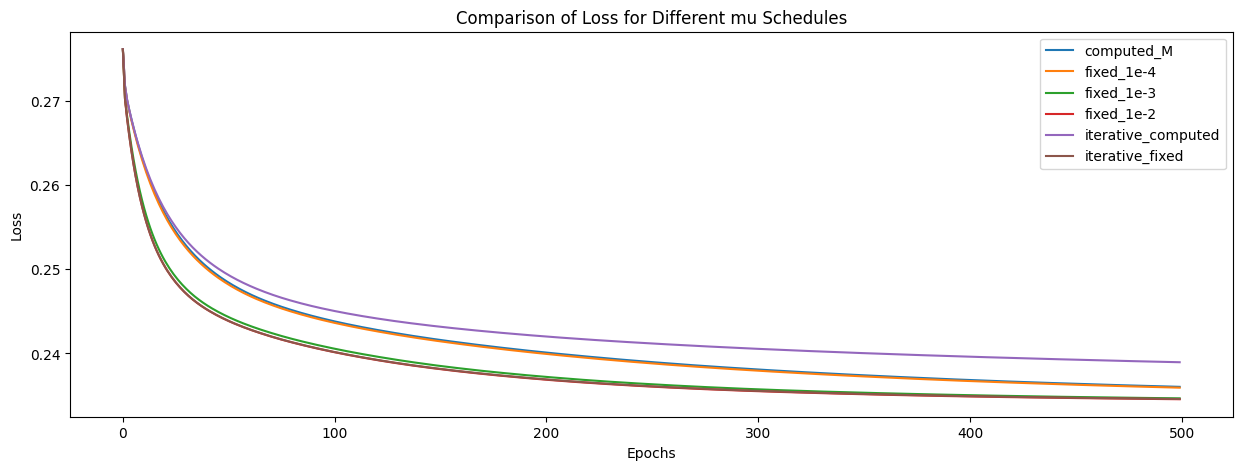

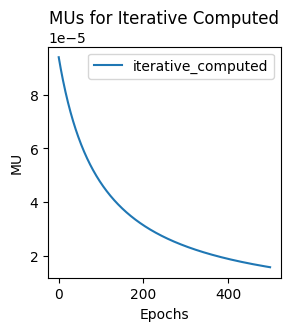

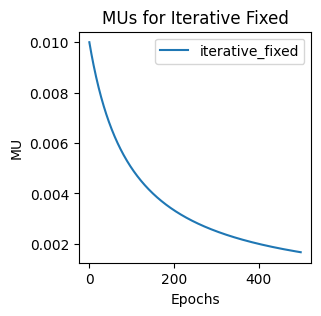

In [55]:
import numpy as np

def smoothed_grid(
    f,
    theta_init,
    A_norm,
    epochs=1000,
    # The three key parameters for L_mu
    M=0.0,
    sigma_2=1.0,
    # `mu` can be either float or a callable function mu(t) returning the current mu
    mu=1e-2,
    momentum_init=0.9,
    gradient_norm_threshold=None,
    decay=0.0,
    mu_min=1e-8
):
    """
    A flexible smoothed optimizer. If mu is a float, we hold it fixed.
    If mu is a callable, we update it each epoch.

    f(theta) -> (loss, grad, None) must be provided.
    """
    # We'll store the parameter dimension from theta_init
    dim = theta_init.shape[0]

    # Momentum
    v = np.zeros_like(theta_init)
    theta = theta_init.copy()
    eta = momentum_init

    history = {"losses": [], "grad_norms": [], "theta": [], "mu": []}

    clbl_bool = ""

    for epoch in range(epochs):
        # 1) Determine the current mu_t
        if callable(mu):
            clbl_bool = 'FINAL'
            # user-supplied schedule
            mu_t = mu(epoch)
            if mu_t < mu_min:
                print(f"Stopping early at epoch {epoch}, mu < {mu_min}")
                break
            history["mu"].append(mu_t)
        else:
            # fixed numeric
            mu_t = mu

        # 2) Compute L_L1 and L_mu for *this epoch*
        L_L1 = (1.0 / (mu_t * sigma_2)) * A_norm
        L_mu = M + L_L1
        nu = 1.0 / L_mu

        # 3) Lookahead step
        theta_look = theta + eta * v

        # Evaluate
        loss, grad, _ = f(theta_look)
        gn = np.linalg.norm(grad)

        history["losses"].append(loss)
        history["grad_norms"].append(gn)
        history["theta"].append(theta_look.copy())

        # stopping condition
        if gradient_norm_threshold is not None and gn < gradient_norm_threshold:
            print(f"Stopping early at epoch {epoch}, grad norm < {gradient_norm_threshold}")
            break

        # 4) Momentum update
        v = eta * v - nu * grad
        theta = theta + v

    print(f"------ {clbl_bool} PARAMETERS ------")
    print(f"{clbl_bool} mu = {mu_t}")
    print(f"{clbl_bool} L_L1 = {L_L1}")
    print(f"{clbl_bool} L_mu = {L_mu}")
    print(f"{clbl_bool} learning rate nu = {nu}")
    print("--------------------------------")
    return theta, history

def mu_schedule_computed(epoch, mu_init, decay):
    """
    Example schedule: mu_init / (1 + decay * epoch), clipped at mu_min
    """
    val = mu_init / (1.0 + decay * epoch)
    return val

mu_grid_search = {
    # 1) A "computed" fixed mu from the formula
    'computed_M': lambda epoch: (A_norm / (M*sigma_2)),  # no scheduling, always the same
    # 2) Several fixed values
    'fixed_1e-4': 1e-4,
    'fixed_1e-3': 1e-3,
    'fixed_1e-2': 1e-2,
    # 3) iterative "computed" schedule
    'iterative_computed': lambda epoch: mu_schedule_computed(
        epoch=epoch,
        mu_init=(A_norm/(M*sigma_2)), # initial mu
        decay=1e-2,                   # or your chosen decay
    ),

    # 4) iterative "fixed" schedule
    'iterative_fixed': lambda epoch: mu_schedule_computed(
        epoch=epoch,
        mu_init=1e-2,  # or some chosen constant
        decay=1e-2,
    )
}

results = {}

for mu_key, mu_value in mu_grid_search.items():
    print("="*50)
    print(f"Running smoothed training with mu_key = {mu_key}")
    print("="*50)
    model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)
    # Pass mu=mu_value (which might be float or callable)
    history = model.train(
        X_syn, y_syn,
        optimizer=smoothed_grid,
        epochs=500,
        A_norm=A_norm,
        M=M,
        sigma_2=sigma_2,
        momentum_init=0.2,
        gradient_norm_threshold=1e-8,
        mu=mu_value  # this is the key part
    )
    # store results for comparative plot
    results[mu_key] = {
        'loss_history': history['losses'],
        'mu_history': history['mu']
        }

# plot results:
plt.figure(figsize=(15,5))
for mu_key, result in results.items():
    plt.plot(result['loss_history'], label=f"{mu_key}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison of Loss for Different mu Schedules")
plt.show()

plt.figure(figsize=(3, 3))
plt.plot(results['iterative_computed']['mu_history'], label='iterative_computed')
plt.xlabel("Epochs")
plt.ylabel("MU")
plt.legend()
plt.title("MUs for Iterative Computed")
plt.show()

plt.figure(figsize=(3, 3))
plt.plot(results['iterative_fixed']['mu_history'], label='iterative_fixed')
plt.xlabel("Epochs")
plt.ylabel("MU")
plt.legend()
plt.title("MUs for Iterative Fixed")
plt.show()

In [29]:
results.keys()

dict_keys(["\n    'iterative_computed': lambda epoch: mu_schedule_computed(\n        epoch=epoch,\n        mu_init=(A_norm/(M*sigma_2)), # initial mu\n        decay=1e-3,                   # or your chosen decay\n        mu_min=1e-6\n    ),\n    iterative_fixed"])

## California

Rank di H: 200 su 200
Sigma2: 4.6200955897288765
Lipschitz constant: 82.55653201080646
------ PARAMETERS ------
M = 82.55653201080646
sigma_2 = 4.6200955897288765
mu = 4467.440034332976
L_L1 = 82.55653201080645
L_mu = 165.1130640216129
nu (learning rate) = 0.006056455955956958
------------------------


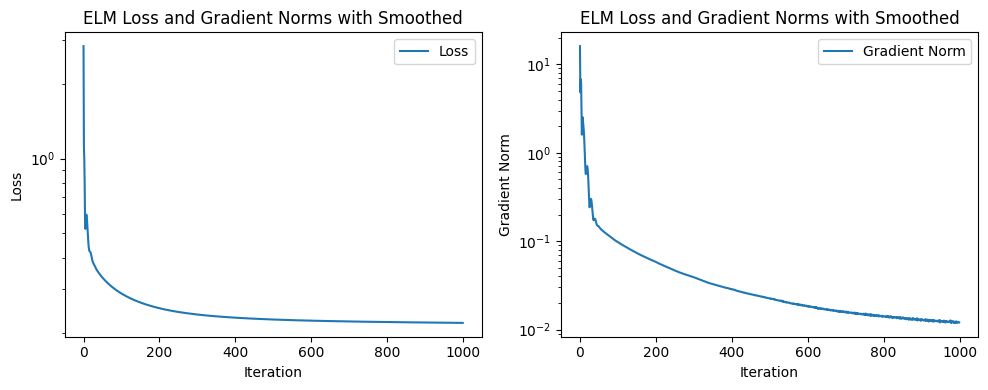

In [58]:
model = ELM(input_size=X_cal.shape[1], hidden_size=200, output_size=1, l1_lambda=0.001, activation='relu', seed=1710)
# 1) Compute the hidden activation matrix once
model.forward(X_cal)
H = model.hidden_layer_output  # shape (N, hidden_size)
rank_H = np.linalg.matrix_rank(H)
print(f"Rank di H: {rank_H} su {H.shape[1]}")

A_norm = np.linalg.norm(H, ord=2)**2  # largest singular value squared

sigma_2 = np.min(np.linalg.eigvals(H.T @ H))  # H.T @ H è quadrata di dim (hidden_size, hidden_size); # strong convexity parameter: minimo autovalore dell'Hessiana
print(f'Sigma2: {sigma_2}')

M = compute_mse_lipschitz_constant(model, X_cal)
print(f"Lipschitz constant: {M}")

history = model.train(
    X_cal, y_cal,
    A_norm = A_norm,
    optimizer=smoothed,
    epochs=1000,
    M = M,
    sigma_2=sigma_2,
    momentum_init=0.9,
    gradient_norm_threshold=1e-6
)

plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

In [60]:
print(f"Initial Loss: {history['losses'][0]}")
print(f"Final Loss: {history['losses'][-1]}")

Initial Loss: 2.826309484332552
Final Loss: 0.21878481301406794
